## Accessing Landsat Collection 2 Level-1 and Level-2 data with the Planetary Computer STAC API

The Planetary Computer's [Landsat](https://landsat.gsfc.nasa.gov/) dataset represents a global archive of [Level-1](https://www.usgs.gov/landsat-missions/landsat-collection-2-level-1-data) and [Level-2](https://www.usgs.gov/landsat-missions/landsat-collection-2-level-2-science-products) data from from [Landsat Collection 2](https://www.usgs.gov/core-science-systems/nli/landsat/landsat-collection-2). The dataset is grouped into two STAC Collections:
- `landsat-c2-l2` for Level-2 data
- `landsat-c2-l1` for Level-1 data

This notebook demonstrates the use of the Planetary Computer STAC API to query for Landsat data. We will start with an example using Level-2 data and follow with a similar example using Level-1 data.

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. 
- The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.
- To use your API key locally, set the environment variable `PC_SDK_SUBSCRIPTION_KEY` or use `pc.settings.set_subscription_key(<YOUR API Key>)`.

In [1]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc
from odc.stac import stac_load
import matplotlib.pyplot as plt

### Choose an area and time of interest

This area is in Redmond, WA, USA, near Microsoft's main campus. We'll search all of 2021. 

In [2]:
bbox_of_interest = [-122.2751, 47.5469, -121.9613, 47.7458]
time_of_interest = "2021-01-01/2021-12-31"

### Search the collection and choose a scene to render

Use [pystac-client](https://github.com/stac-utils/pystac-client) to perform the search over the Landsat Collection 2 Level-2 collection (`landsat-c2-l2`), specifying we want results with less than 10% cloud cover.

In [3]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# PRIOR TO RELEASE, CHANGE THE COLLECTION TO "landsat-c2-l2"
search = catalog.search(
    collections=["landsat-8-c2-l2"],
    bbox=bbox_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 7 Items


Let's find the least cloudy of the bunch.

In [4]:
selected_item = sorted(items, key=lambda item: eo.ext(item).cloud_cover)[0]

print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)

Choosing LC08_L2SP_046027_20210725_02_T1 from 2021-07-25 with 0.38% cloud cover


### Available assets

In additon to numerous metadata assets, each EO band is a separate asset.

In [5]:
max_key_length = len(max(selected_item.assets, key=len))
for key, asset in selected_item.assets.items():
    print(f"{key.rjust(max_key_length)}: {asset.title}")

                      ANG: Angle Coefficients File
                    SR_B1: Coastal/Aerosol Band (B1)
                    SR_B2: Blue Band (B2)
                    SR_B3: Green Band (B3)
                    SR_B4: Red Band (B4)
                    SR_B5: Near Infrared Band 0.8 (B5)
                    SR_B6: Short-wave Infrared Band 1.6 (B6)
                    SR_B7: Short-wave Infrared Band 2.2 (B7)
                    ST_QA: Surface Temperature Quality Assessment Band
                   ST_B10: Surface Temperature Band (B10)
                  MTL.txt: Product Metadata File
                  MTL.xml: Product Metadata File (xml)
                  ST_DRAD: Downwelled Radiance Band
                  ST_EMIS: Emissivity Band
                  ST_EMSD: Emissivity Standard Deviation Band
                  ST_TRAD: Thermal Radiance Band
                  ST_URAD: Upwelled Radiance Band
                 MTL.json: Product Metadata File (json)
                 QA_PIXEL: Pixel Quality Assessm

### Render a natural color image of the AOI

We'll start by loading the red, green, and blue bands for our area of interest into an xarray dataset using `odc-stac`. We will also load the nir08 band for use in computing an NDVI value in a later example. Note that we pass the `sign` function from the [planetary-computer](https://github.com/microsoft/planetary-computer-sdk-for-python) package so that `odc-stac` can supply the required [Shared Access Signature](https://docs.microsoft.com/en-us/azure/storage/common/storage-sas-overview) tokens that are necessary to download the asset data.

In [6]:
# PRIOR TO RELEASE, THESE BAND KEYS NEED TO BE CHANGED TO THEIR COMMON NAMES:
# "nir08", "red", "green", "blue"
bands_of_interest = ["SR_B5", "SR_B4", "SR_B3", "SR_B2"]
data = stac_load(
    [selected_item], bands=bands_of_interest, patch_url=pc.sign, bbox=bbox_of_interest
).isel(time=0)
data

<xarray.Dataset>
Dimensions:      (y: 747, x: 795)
Coordinates:
    time         datetime64[ns] 2021-07-25T18:55:39.475647
  * y            (y) float64 5.289e+06 5.289e+06 ... 5.266e+06 5.266e+06
  * x            (x) float64 5.543e+05 5.544e+05 ... 5.781e+05 5.781e+05
    spatial_ref  int32 32610
Data variables:
    SR_B5        (y, x) uint16 7182 7216 7248 7288 ... 18508 16865 18852 25114
    SR_B4        (y, x) uint16 7152 7192 7226 7269 7294 ... 8128 8774 8552 7981
    SR_B3        (y, x) uint16 7483 7523 7560 7597 7596 ... 8673 8987 8925 8693
    SR_B2        (y, x) uint16 7329 7397 7465 7535 7525 ... 8091 8655 8274 7965
Attributes:
    crs:           EPSG:32610
    grid_mapping:  spatial_ref

Now we'll convert our xarray Dataset to a DataArray and plot the RGB image. We set `robust=True` in `imshow` to avoid manual computation of the color limits (vmin and vmax) that are necessary for data not scaled to between 0-1 while also eliminating extreme values that can cause a washed out image.

Text(0.5, 1.0, 'Natural Color, Redmond, WA')

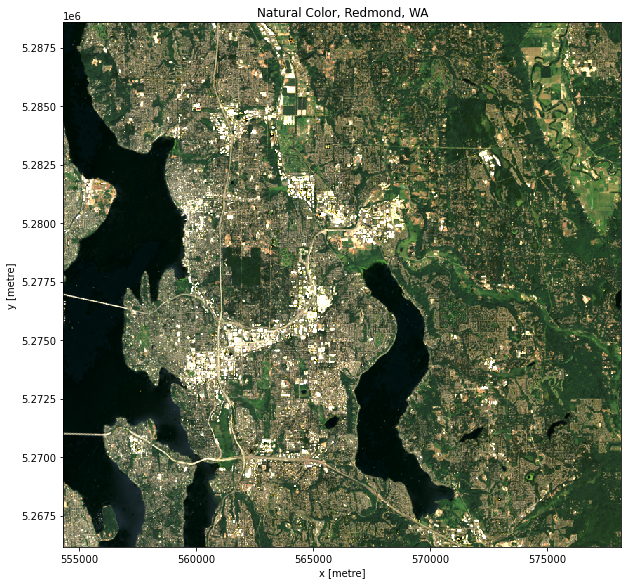

In [7]:
# PRIOR TO RELEASE, CHANGE "SR_B5" TO "nir08"
rgb = data.drop_vars("SR_B5")
rgb = rgb.to_array()

fig, ax = plt.subplots(figsize=(10, 10))
rgb.plot.imshow(robust=True, ax=ax)
ax.set_aspect(aspect="equal", adjustable="box")
ax.set_title("Natural Color, Redmond, WA")

### Render an NDVI image of the AOI

Landsat has several bands, and with them we can go beyond rendering natural color imagery; for example, the following code computes a [Normalized Difference Vegetation Index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) using the near-infrared and red bands. Note that we convert the red and near infrared bands to a data type that can contain negative values; if this is not done, negative NDVI values will be incorrectly stored.

Text(0.5, 1.0, 'NDVI, Redmond, WA')

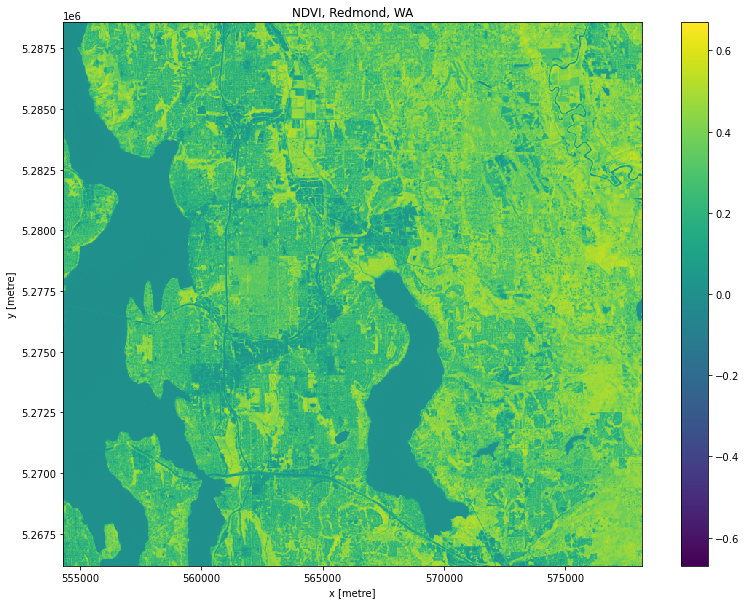

In [13]:
# PRIOR TO RELEASE, CHANGE "SR_B4" to "red" "SR_B5" TO "nir08"
red = data["SR_B4"].astype("float")
nir = data["SR_B5"].astype("float")
ndvi = (nir - red) / (nir + red)

fig, ax = plt.subplots(figsize=(14, 10))
ndvi.plot.imshow(ax=ax, cmap="viridis")
ax.set_aspect(aspect="equal", adjustable="box")
ax.set_title("NDVI, Redmond, WA")

### Landsat Collection 2 Level-1 Data

Thus far we have worked with Landsat Collection 2 Level-2 data, which is processed to a consistent set of surface reflectance and surface temperature [science products](https://www.usgs.gov/landsat-missions/landsat-science-products). 

The Planetary Computer also hosts Collection 2 Level-1 data (top of atmosphere values) acquired by the [Multispectral Scanner System](https://landsat.gsfc.nasa.gov/multispectral-scanner-system/) (MSS) onboard Landsat 1 through 5. These data do not include a blue band, so a natural color image is not possible. We will plot a color infrared image from the nir08, red, and green bands instead.

As before, we use pystac-client to search over the `landsat-c2-l1` collection for the same area of interest and less than 10% cloud cover.

In [14]:
# PRIOR TO RELEASE, CHANGE THE COLLECTION TO "landsat-c2-l1"
search = catalog.search(
    collections=["landsat-8-c2-l2"],
    bbox=bbox_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 7 Items


Choose the least cloudy Item.

In [15]:
selected_item = sorted(items, key=lambda item: eo.ext(item).cloud_cover)[0]

print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)

Choosing LC08_L2SP_046027_20210725_02_T1 from 2021-07-25 with 0.38% cloud cover


Use `odc-stac` to load only the bands and area we are interested in and plot.

Text(0.5, 1.0, 'Color Infrared, Redmond, WA')

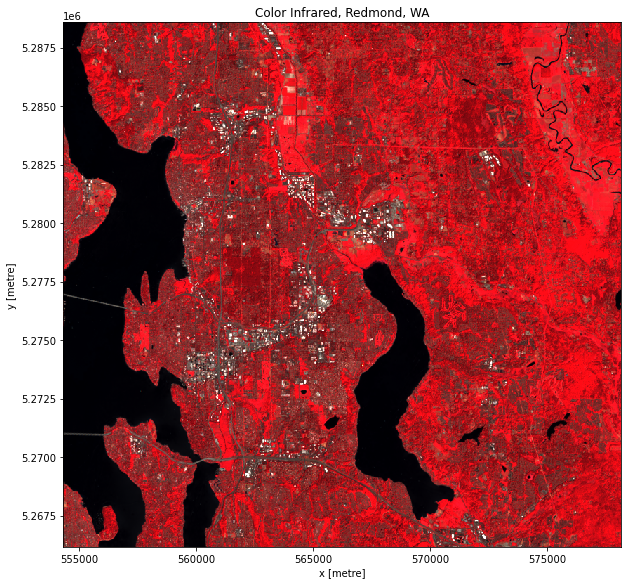

In [16]:
# PRIOR TO RELEASE, THESE BAND KEYS NEED TO BE CHANGED TO THEIR COMMON NAMES:
# "nir08", "red", "green"
bands_of_interest = ["SR_B5", "SR_B4", "SR_B3"]
data = stac_load(
    [selected_item], bands=bands_of_interest, patch_url=pc.sign, bbox=bbox_of_interest
).isel(time=0)

cir = data.to_array()

fig, ax = plt.subplots(figsize=(10, 10))
cir.plot.imshow(robust=True, ax=ax)
ax.set_aspect(aspect="equal", adjustable="box")
ax.set_title("Color Infrared, Redmond, WA")